In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Wrapper.W_momen_factor_create import *
from Wrapper.W_pre_factor_data_mani import *
from Wrapper.W_pre_opt_data_mani import wrapper_df_preparation
from Wrapper.W_pre_opt_obj_func import (wrapper_objective_compo_creation,
                                               wrapper_objective_func)
import scipy.optimize as opt
from Wrapper.Moduel.M_FactorCreator import FactorsConstruction
from Wrapper.W_pre_opt_factor_standardize import wrapper_standardize_factor
from Wrapper.Moduel.M_SupportFunction import (weight_prediction,get_new_factor_value)
from Wrapper.W_opt_ppp import PPP_optimize
from Wrapper.Moduel.M_BackTest import BackTest
from Wrapper.Moduel.M_BenchmarkBacktest import BenchmarkStrategy, BenchmarkIndex
from Wrapper.Moduel.M_PerforEvalu import ModelFreeEvaluation


def plot_multiple_series(dataframe,date_name, colname_list):
    plt.figure(figsize = (20,10))
    for colname in colname_list:
        plt.plot(dataframe[date_name],dataframe[colname])

## Data Preparation 

In [2]:
price_file = "Data/Price.csv"
price_df, ticker_list = wrapper_import_data(price_file)
return_df, factor_df = wrapper_return_calculation(price_df, 
                           ticker_list,
                           look_back_list=[12],skip=0,
                           target_name='price',frequency='BM')
factor_df, return_df  = wrapper_factor_return_output(return_df,factor_df)
factor_list = ["momentum_12"]
reshape_dic = wrapper_df_preparation(return_df,factor_df,factor_list)
factor_dic = reshape_dic["factor_dic"]

/Users/sunnyyang/Desktop/2019.11.29 Version/Wrapper/Moduel/M_PanelFormatter.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[shift_target] = x[shift_target].shift(shift_step)


In [3]:
ret_mat = reshape_dic["ret_mat"]
factor_dic.update({'ret_mat':ret_mat})
ret_mat_test = pd.DataFrame(ret_mat)
ret_mat_test = ret_mat_test.shift(1)
ret_mat_test = np.array(ret_mat_test)
date_df = return_df[return_df['ticker']=='AEP']
date = date_df['date']

In [4]:
general_dic = {'ticker_list':ticker_list,'ret_mat_test':ret_mat_test,'factor_list':factor_list,'date':date}
factor_dic = wrapper_standardize_factor(ticker_list,factor_dic)
data_dict ={'strategy_specific_data':factor_dic,'general_data':general_dic}

## Strategy Back Test

### Back Test Detail

In [5]:
def func(x):
    final_weight = PPP_optimize(x,ticker_list=ticker_list,factor_list=factor_list)
    return final_weight

strategy_est_length = 10
end_index = 200
update = 1

### Back Test Implementation

In [6]:
back_obj = BackTest(data_dict,func)
rp_storage, weight_storage,date_storage = back_obj.historical_backtest(est_length = strategy_est_length,
                                                                       start_index=101,
                                                                       end_index=end_index,
                                                                       update=1,
                                                                       fixed=True)

Optimization terminated successfully.
         Current function value: 0.245711
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.248077
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.246585
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.242312
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.248355
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.244327
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.246907
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.249859
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.249028
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.248603
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.248196
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.238004
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.245741
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.240856
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

### Back Test Result Evaluation

In [7]:
obj = BenchmarkStrategy(rp_storage,date_storage)

In [8]:
final_return_df = obj.equalweight(data= data_dict ,asset_num = 5, update=1,fixed=True)

In [9]:
obj_1 = ModelFreeEvaluation(final_return_df['strategy_return'],final_return_df['date'])
obj_2 = ModelFreeEvaluation(final_return_df['benchmark_return'],final_return_df['date'])

In [10]:
sharpe_1 = obj_1.sharpe_ratio(annul_freq=12,rf=0.0016)
sharpe_2 = obj_2.sharpe_ratio(annul_freq=12,rf=0.0016)

In [11]:
cum_ret_1 = obj_1.cum_ret_calculation()
cum_ret_2 = obj_2.cum_ret_calculation()

In [36]:
dd1, mdd1, ddd1 = obj_1.drawdown_calculation()
dd2, mdd2, ddd2 = obj_2.drawdown_calculation()

In [13]:
final_return_df['cum_ret_1']=cum_ret_1
final_return_df['cum_ret_2']=cum_ret_2
final_return_df['dd1'] = dd1
final_return_df['dd2'] = dd2

In [14]:
sharpe_1

0.8445274242566363

In [15]:
sharpe_2

0.7173352208160747

In [16]:
mdd1

-0.16627120558855846

In [17]:
mdd2

-0.1614199500250234

In [18]:
ddd1

13.0

In [19]:
ddd2

13.0

In [20]:
ret_series = final_return_df.strategy_return
date_series = final_return_df.date

In [21]:
obj = BenchmarkIndex(ret_series,date_series)

In [22]:
index_comparison = obj.sp500_index_comparison(ret=True)

In [23]:
obj_3 = ModelFreeEvaluation(index_comparison['sp500'],index_comparison['date'])

In [24]:
sharpe_3 = obj_3.sharpe_ratio(annul_freq=12,rf=0.0016)

In [28]:
cum_ret_3 = obj_3.cum_ret_calculation()

In [33]:
dd3, mdd3, ddd3 = obj_3.drawdown_calculation()

In [38]:
final_return_df['cum_ret_3']=cum_ret_3

ValueError: Length of values does not match length of index

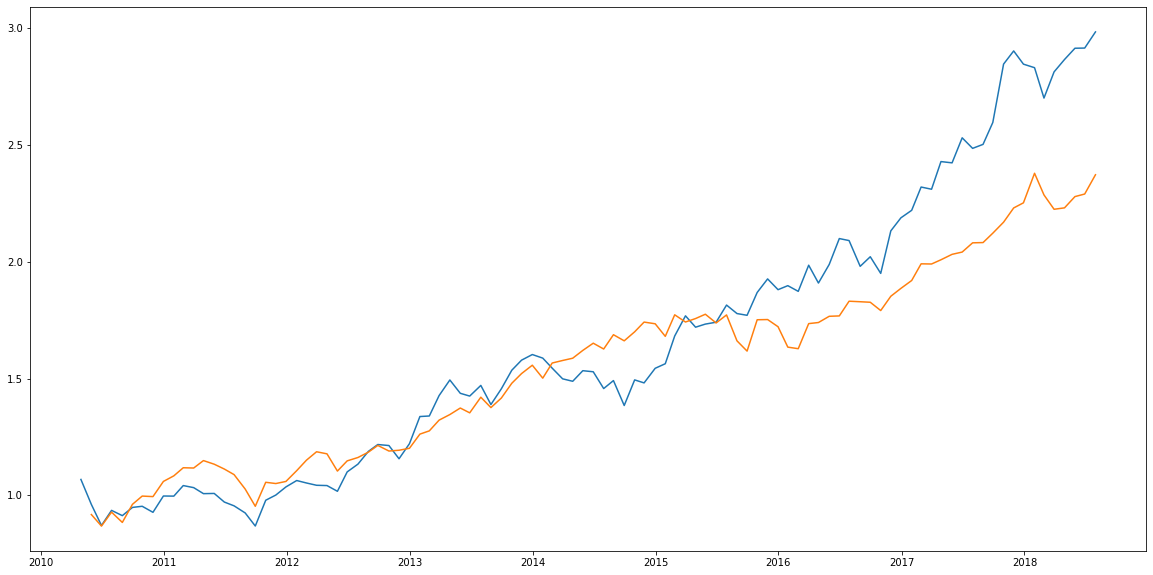

In [47]:
plot_multiple_series(final_return_df,"date", ["cum_ret_1","cum_ret_3"])

In [40]:
final_return_df

,benchmark_return,date,strategy_return,cum_ret_1,cum_ret_2,dd1,dd2,cum_ret_3
0,0.065295,2010-04-30,0.068302,1.068302,1.065295,0.000000,0.000000,NaN
1,-0.098886,2010-05-31,-0.100168,0.961292,0.959952,-0.038708,-0.040048,0.918024
2,-0.098083,2010-06-30,-0.093734,0.871186,0.865797,-0.128814,-0.134203,0.868559
3,0.073255,2010-07-30,0.074228,0.935852,0.929221,-0.064148,-0.070779,0.928296
4,-0.023605,2010-08-31,-0.024075,0.913322,0.907287,-0.086678,-0.092713,0.884249
...,...,...,...,...,...,...,...,...
95,0.033756,2018-03-30,0.041484,2.813758,2.365889,-0.030904,-0.075736,2.225408
96,0.013364,2018-04-30,0.018841,2.866773,2.397506,-0.012645,-0.063384,2.231459
97,0.023510,2018-05-31,0.016843,2.915058,2.453870,0.000000,-0.041365,2.279677
98,-0.003260,2018-06-29,0.000264,2.915827,2.445870,0.000000,-0.044491,2.290716
